# STAT DESC ET ETUDES DE CAS 
## PREMIERES TENDANCES AVEC LES STATS DESC


Le but de cette partie est d'évaluer les premières tendances que l'on pourrait remarquer. Notre objectif est de voir si on remarque facilement des spécifités géographiques dans la répartition des maladies

On importe tous les modules nécéssaires :

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
!pip install --upgrade xlrd #colab bug verson xlrd
!pip install geopandas
!pip install pandas fiona shapely pyproj rtree
!pip install contextily
!pip install pygeos
!pip install topojson
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
#!pip install requests py7zr geopandas openpyxl tqdm s3fs PyYAML xlrd
#!pip install git+https://github.com/inseefrlab/cartiflette@80b8a5a28371feb6df31d55bcc2617948a5f9b1a

On importe nos base de travail issue de sources diverses mais généralement insee + data gouv (à modifier)

In [3]:
#La base de données effectifs, notre base de travai principale qui nous renseigne sur les pathologies, issue de datagouv 
eff = pd.read_csv("effectifs.csv", sep = ";", encoding = 'utf-8', engine = 'python')

On réalise quelques histogrammes pour voir quels sont les tendances qui se dessinent :

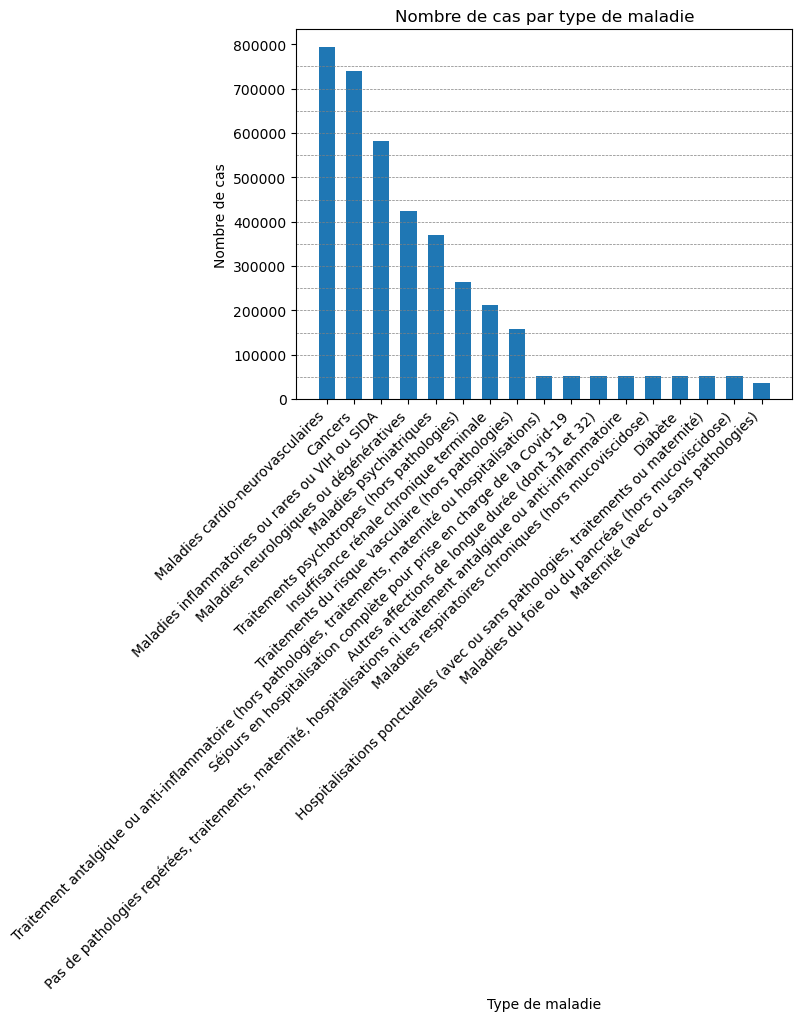

In [4]:
#Diagramme en barres sur le nombre de cas par type de maladie

# Compter le nombre de cas par type de maladie
counts = eff['patho_niv1'].value_counts()

# Créer le diagramme en barres
plt.bar(counts.index, counts.values,  width=0.6)
plt.xlabel('Type de maladie')
plt.ylabel('Nombre de cas')
plt.title('Nombre de cas par type de maladie')

# Ajouter des lignes horizontales en arrière-plan
for y in range(0, max(counts.values) + 1, 50000):  # Ajuster l'espacement des lignes selon vos besoins
    plt.axhline(y, color='gray', linestyle='--', linewidth=0.5)

# Rotation des étiquettes en diagonale
plt.xticks(rotation=45, ha='right')

plt.show()

In [ ]:
#j'ai enelvé la cellule sur le sexe parceque les résultats étaient un peu curieux mais à voir 

On remarque que parmi les pathologies de niveau 1 (le niveau le moins précis), les cancers sont avec les maladies cardio vasculaires les premières maladies dont sont atteints les individus de la base. Il est donc intéressant à cet égard de regarder ce type de maladie pour avoir des résultats signoificatifs par la suite.

### Etudes de la pollution comme facteur possible de maladie 

Nous avons considéré comme le suggère de nombreux rapports que la pollution était une des sources principales de maladies en France et dans le monde. Nous avons donc considéré pertinent de réaliser quelques statistiques descriptives sur la polluton afin de déterminer si la pollution localisée dans certaine zones pouvaient être la  
cause de certaines de maladie spécifiques sur certains territoires 


On importe la base polluton qui vient de (à modifier)

In [13]:
data_pollution = pd.read_csv("https://koumoul.com/data-fair/api/v1/datasets/igt-pouvoir-de-rechauffement-global/convert", encoding = 'utf-8')

In [ ]:
#Je finirai la pollution après qu'on se soit mis d'accord avec Théo sur comment faire 
#Idée : pouvoir utiliser le graphique sur les sources de pollution pour faire les études de cas

## ETUDES DE CAS 
### LES EFFETS DE LA POLLUTION : LES CANCERS DE LA PROSTATE SONT-ILS PLUS NOMBREUX EN BRETAGNE ? 

INSERER LA SOURCE DE POLLUTION DANS LE 29 !!!

Comme nous l'avons vu précédemment, la pollution varie selon les territoires mais les sources de pollution également. On peut alors se demander
Dans quelle mesure on peut essayer d'anticiper qu'un nombre important d'individus soient atteint par une certaine maladie ne  fonction du lieu ou on se trouve.
Nous avons déccider de nous pencher sur un cas qui a déjà marqué l'actualié : la polluton agricole en Bretagne. D'apres la fondation pour la nature et l'homme
la pollution liée à l'agriculture favoriserait un cetain nombre de maladies comme les cancers de la prostate. Nous allons donc essayer de voir si dans le département 
29, le Finistère, le taux de cancer de la prostate parmi la population ets plu sélevé que la moyenne. 

Pour se faire, nous allons recourir à une copie de notre base de données intiale que nous renommeront base_grande. Cette va être retravaillée afin de convenir à notre démarche. On va par exemple changer les classes d'âges et les transformer en un age unique. On va aussi utiliser dummies afin de créer des variables catégorielles sur chacun de nos pathologie de niveau 2 pour pouvoir isoler plus facilement les individus atteints d'un cancer de la prostate. 

In [16]:
#PaR rapport aux autres histogramme ici on va prendre pathoniv2 pour les dummies 
base_grande = pd.read_csv("effectifs.csv", sep = ";", encoding = 'utf-8', engine = 'python')
base_grande.shape
base_grande = base_grande.dropna()
base_grande = pd.get_dummies(base_grande, prefix = 'indicatrice_', columns=['patho_niv2'], dtype='int')


liste_var = base_grande.columns[17:]
liste_bis = []
for i in liste_var : 
    liste_bis.append(i)
indicatrice_patho_niv1 = liste_bis

liste_auxil = base_grande['cla_age_5'].unique()
inter_excl = ('95et+', 'tsage', np.nan)

inter_def = []
for i in liste_auxil :
    if i in inter_excl : 
        inter_def = inter_def
    else : 
        inter_def.append(i)
classe_age = []
for i in base_grande['cla_age_5'] : 
    if i in inter_def :
        temp = i.split('-')
        temp[0] = int(temp[0])
        temp[1] = int(temp[1])
        age = (temp[1] + temp[0])/2
    elif i == 'tsage' : 
        age = np.nan
    elif i == '95et+' : 
        age = 100
    else : 
        age = np.nan
    classe_age.append(age)
base_grande.loc[:,'classe_age'] = classe_age

On créer ensuite une nouvelle base de donée de laquelle on ne garde que les colonnes qui nous sont utiles à savoir le département et la variable catégorielle qui porte 
sur la pathologie étudiée

In [20]:
#On supprime les espaces dans le noms des colonnes 
base_grande.columns = base_grande.columns.str.replace(' ', '_')

model_prostate = base_grande[['dept', 'classe_age','indicatrice__Cancer_de_la_prostate','sexe','region']]

In [22]:
#On prend la liste des départements observés afin de généralisé notre démarche
valeurs_uniques = model_prostate['dept'].unique()
#print(valeurs_uniques)

resultats = model_prostate.groupby('dept')['indicatrice__Cancer_de_la_prostate'].agg(['count', 'sum'])

# Renommer les colonnes
resultats.columns = ['pop_i', 'pop_i2']

# Remplacer les valeurs manquantes par 0
resultats['pop_i2'].fillna(0, inplace=True)

# Initialiser la variable pour la moyenne
moyenne_totale = 0

# Calculer le pourcentage de cancer de la prostate par département et afficher les résultats
for index, row in resultats.iterrows():
    if row['pop_i'] != 0:
        pourcentage_cancer = (row['pop_i2'] / row['pop_i']) * 100
        moyenne_totale += pourcentage_cancer
        print(f"Il y a {pourcentage_cancer:.2f}% de cancer de la prostate dans le département {index}.")
    else:
        print(f"Aucun individu dans le département {index} dans votre DataFrame.")

# Calculer la moyenne totale
if len(resultats) > 0:
    moyenne_totale /= len(resultats)
    print(f"\nLa moyenne totale des pourcentages de cancer de la prostate est {moyenne_totale:.2f}%.")
else:
    print("\nAucun résultat à moyenner, car tous les départements ont une population de 0.")



['971' '973' '999' '75' '94' '95' '25' '58' '27' '61' '62' '80' '54' '67'
 '53' '33' '40' '47' '86' '34' '46' '48' '65' '82' '09' '01' '63' '69'
 '74' '2B' '974' '976' '91' '92' '28' '37' '41' '45' '89' '90' '14' '10'
 '51' '52' '57' '08' '49' '72' '85' '35' '56' '24' '64' '12' '66' '03'
 '38' '42' '06' '84' '78' '18' '21' '02' '68' '17' '23' '79' '87' '30'
 '31' '32' '15' '13' '83' '93' '36' '70' '55' '44' '16' '19' '11' '43'
 '04' '05' '2A' '972' '77' '88' '29' '26' '07' '39' '50' '59' '60' '76'
 '81' '71' '73' '22']
Il y a 1.76% de cancer de la prostate dans le département 01.
Il y a 1.78% de cancer de la prostate dans le département 02.
Il y a 1.88% de cancer de la prostate dans le département 03.
Il y a 1.89% de cancer de la prostate dans le département 04.
Il y a 1.97% de cancer de la prostate dans le département 05.
Il y a 1.69% de cancer de la prostate dans le département 06.
Il y a 1.88% de cancer de la prostate dans le département 07.
Il y a 1.73% de cancer de la prostate dan

On constate alors qu'un 1,73% de la population du Finistère est atteinte d'un cancer de l' u n   ce, ce qui est moins que la moyenne nationale. Cela nous renseine sur la 
difficulté qu'il peut en réalité y avoir à prédire le nombre de maladie dans un département en fonction de certaine de ses caractéristiques prises isolément. C'est ausi ce que 
semblait affirmer l'article de la fondation pour la nature et l'homme (https://www.fnh.org/pesticides-hauts-risques-pour-la-sante-des-agriculteurs-et-les-riverains/) quand elle affirme que
"cette cancérogénicité est validée formellement mais pas statistiquement". 

On tient néanmoins à souligner que cela ne signifie pas qu'étuder le département ne puisse pas donner de résultats significatifs. Le cas des outre mer est assez frappant. En effet, en France métropolitaine 
seuls le Gers(32), la Creuse(23), et l'Ariège(09) le Lot(46) et la Lozère(48) dépasse les 2% de la population atteinte par un cancer de la prostate. Alors que 3 départements d'outre mer sur cinq
la Goudeloupe (971), la Guyane (973) et la Mayotte (976) se place au dessus de 2%. Autrement dit, certaines autres variables spécifiques à ce département doivent permettre d'expliquer la porportion
aussi élevé de cancer de la prostate en outre mer. 

### ETUDES DE CAS 2 : PEUT ON ESTIMER LA PROPORTION D'HOSPITALISATION EN FONCTION DU REVENU DES HABITANTS D'UN DEPARTEMENT DONNE ? 

L'idée fondamentale derriere ce questionnement c'est celle de l'importance que les individus accordent à leur santé en fonction de leurs revenus. 
On pourrait par exemple estimer confromément a TEL ARTICLE DE SOCIO A INSERER  que les indivdus ayant les revenus les plus élevés soigneraient plus souvent.
On va alors pour avoir une bonne idée du revenus des individus au sein d'un département utiliser le classemnt PIB par habitant des déprtements et
ainsi en comparer plusieurs très élognés dans le classement. 


